In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
import random
from random import shuffle
from skimage.transform import rotate
import scipy.ndimage

# Loading Indian Pines dataset 


The data is organized into pixels, each representing a small area on the ground, and for each pixel, there are measurements of various characteristics, like spectral reflectance, which helps in identifying different land cover types. Essentially, it's a detailed snapshot of the Indian Pines area from above, with information that can be used for various purposes like land use planning, agriculture monitoring, or environmental studies.

In [53]:
def loadIndianPinesData():
    data_path = os.path.join(os.getcwd(),'Data')
    data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
    labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    
    return data, labels
   

# Splitting data into training and testing sets data

In [54]:
def splitTrainTestSet(X, y, testRatio=0.10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=345,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

# Oversampling weak classes to balance data
    Weak classes may lead to bias in the model. Oversampling these classes ensures that the model has sufficient examples to learn their characteristics effectively and prevents bias towards dominant classes.


In [55]:
def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY


# Standardizing data.

    Standardizing the data ensures that each feature has a mean of 0 and a standard deviation of 1. 
    This makes training more stable and helps algorithms converge faster.

In [56]:
def standartizeData(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    scaler = preprocessing.StandardScaler().fit(newX)  
    newX = scaler.transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
    return newX, scaler

 # Applying PCA for dimensionality reduction.

    Hyperspectral data often has high dimensionality, leading to increased computational complexity and potential overfitting. 
    PCA reduces the dimensionality of the data while preserving the most important information, thus improving computational efficiency and reducing overfitting.

In [57]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca


# Padding data with zeros.

    Padding the data helps prevent edge effects when extracting patches,ensuring that patches near the edges of the image are complete and not cut off.

In [58]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX


# Creating patches from data.

    Creating patches allows the model to capture spatial information from the hyperspectral data. 
    This is important for preserving the spatial context of the data, which is crucial for accurate land cover classification.

In [59]:
def createPatches(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels



# Data augmentation for training.

    Data augmentation introduces variations in the training data, making the model more robust and reducing overfitting. 
    We used augmentation techniques like flipping upside down, flipping from left to right, and rotating the input data

In [60]:
def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.rotate(patch, no,axes=(1, 0),
                                                               reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    
    
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    
    return X_train

# Saving preprocessed data.

    Saving the preprocessed data ensures that the same data can be used for model evaluation and future experiments, without the need to repeat the preprocessing steps.

In [61]:
def savePreprocessedData(X_trainPatches, X_testPatches, y_trainPatches, y_testPatches, windowSize, wasPCAapplied = False, numPCAComponents = 0, testRatio = 0.25):
    if wasPCAapplied:
        with open("X_trainPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open("X_testPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open("y_trainPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open("y_testPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
    else:
        with open("XtrainWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open("XtestWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open("ytrainWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open("ytestWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
            
            

In [62]:
# Load the Global values (windowSize, numPCAcomponents, testRatio) from the text file global_variables.txt
myFile = open('global_variables.txt', 'r') 
file = myFile.readlines()[:]


for line in file:

    if line[0:3] == "win":

        ds = line.find('=')
        windowSize = int(line[ds+1:-1],10)

    elif line[0:3] == "num":

        ds = line.find('=')
        numPCAcomponents = int(line[ds+2:-1],10)

    else:

        ds = line.find('=')
        testRatio = float(line[ds+1:])


In [63]:
# Global Variables
#numPCAComponents = 30
#windowSize = 5
#testRatio = 0.25

# Data exploration

In [64]:
X, y = loadIndianPinesData()

In [65]:
#shape of the dataset
print("pinesdata_shape", X.shape) 
print("groundtruth_shape", y.shape)

pinesdata_shape (145, 145, 200)
groundtruth_shape (145, 145)


In [66]:
df = pd.DataFrame(X.reshape(X.shape[0] * X.shape[1], -1))

df.columns = [f'band_{i}' for i in range(1, df.shape[-1] + 1)]
df['class'] = y.ravel()
print('Each Row corresponds to a pixel, a column is the band value of that pixel')
print(f'There are in total {df["class"].nunique()} classes, 0 being unclassified')
df.head()

Each Row corresponds to a pixel, a column is the band value of that pixel
There are in total 17 classes, 0 being unclassified


,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,band_10,...,band_192,band_193,band_194,band_195,band_196,band_197,band_198,band_199,band_200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


In [67]:
df.describe()

,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,band_10,...,band_192,band_193,band_194,band_195,band_196,band_197,band_198,band_199,band_200,class
count,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,...,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000
mean,2957.363472,4091.321237,4277.502259,4169.956671,4516.678668,4790.595149,4848.317574,4714.732509,4668.904828,4439.065541,...,1061.927848,1060.210273,1063.276813,1050.048514,1040.201141,1043.370321,1030.194816,1015.571463,1008.513579,4.224923
std,354.918708,230.390005,257.827640,280.761254,346.035984,414.382138,469.247667,491.728349,533.232855,539.908195,...,38.843805,38.712195,41.920969,34.242725,26.452672,29.794418,20.865106,11.386402,7.050921,5.281972
min,2560.000000,2709.000000,3649.000000,2810.000000,3840.000000,4056.000000,4004.000000,3865.000000,3775.000000,2792.000000,...,998.000000,999.000000,999.000000,993.000000,990.000000,992.000000,989.000000,986.000000,981.000000,0.000000
25%,2602.000000,3889.000000,4066.000000,3954.000000,4214.000000,4425.000000,4421.000000,4263.000000,4173.000000,3940.000000,...,1026.000000,1024.000000,1024.000000,1019.000000,1016.000000,1016.000000,1012.000000,1006.000000,1004.000000,0.000000
50%,2780.000000,4106.000000,4237.000000,4126.000000,4478.000000,4754.000000,4808.000000,4666.000000,4632.000000,4404.000000,...,1053.000000,1052.000000,1054.000000,1043.000000,1033.000000,1035.000000,1026.000000,1014.000000,1009.000000,0.000000
75%,3179.000000,4247.000000,4479.000000,4350.000000,4772.000000,5093.000000,5198.000000,5100.000000,5084.000000,4860.000000,...,1099.000000,1098.000000,1104.000000,1083.000000,1066.000000,1072.000000,1050.000000,1024.000000,1014.000000,10.000000
max,4536.000000,5744.000000,6361.000000,6362.000000,7153.000000,7980.000000,8284.000000,8128.000000,8194.000000,7928.000000,...,1287.000000,1289.000000,1315.000000,1258.000000,1201.000000,1245.000000,1167.000000,1076.000000,1036.000000,16.000000


There are 16 meaningful classes in total:

'Alfalfa', 'Corn-notill', 'Corn-min', 'Corn', 'Grass/Pasture', 'Grass/Trees', 'Grass/pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybeans-notill', 'Soybeans-min', 'Soybean-clean', 'Wheat', 'Woods', 'Bldg-Grass-Tree-Drives', 'Stone-steel towers'

## Visualization of different spectral bands 

Each band corresponds to a panchromatic image of dimensions 145x145 in the spacial plan (220 total)

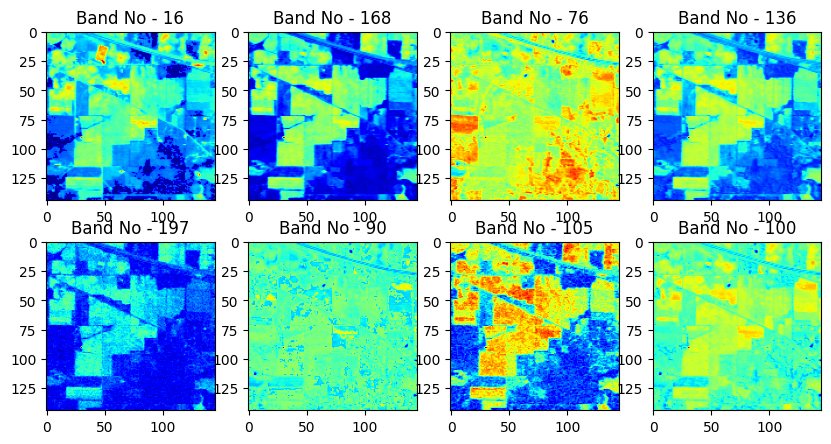

In [68]:
#visualizing the bands
fig = plt.figure(figsize = (10, 5))

for i in range(1,9 ):
    fig.add_subplot(2,4, i)
    band = np.random.randint(X.shape[2])
    plt.imshow(X[:,:,band], cmap = "jet")
    plt.title(f"Band No - {band}")

## Spectral Signature Visualization

C:\Users\tasni\AppData\Local\Temp\ipykernel_28032\1580931677.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df.where(df['class']!=0), x='class', palette='cubehelix')


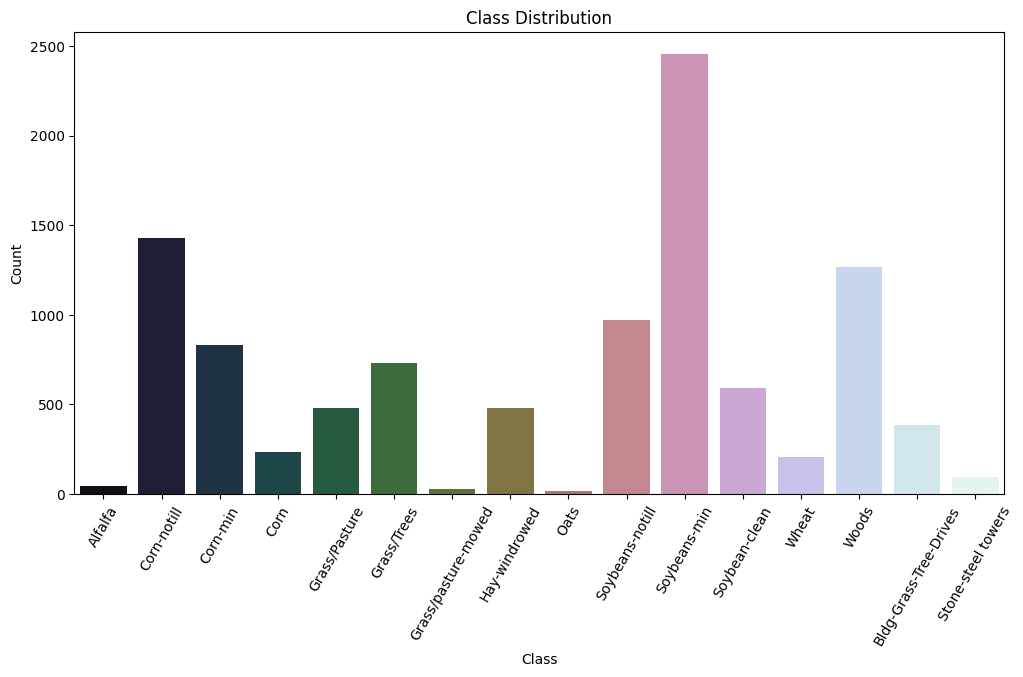

In [69]:
# Plot the class distribution using Seaborn
classes = ['Alfalfa', 'Corn-notill', 'Corn-min', 'Corn', 'Grass/Pasture', 'Grass/Trees', 'Grass/pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybeans-notill', 'Soybeans-min', 'Soybean-clean', 'Wheat', 'Woods', 'Bldg-Grass-Tree-Drives', 'Stone-steel towers']
plt.figure(figsize=(12, 6))
sns.countplot(data=df.where(df['class']!=0), x='class', palette='cubehelix')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=range(len(classes)), labels=classes,rotation=60)
plt.show()

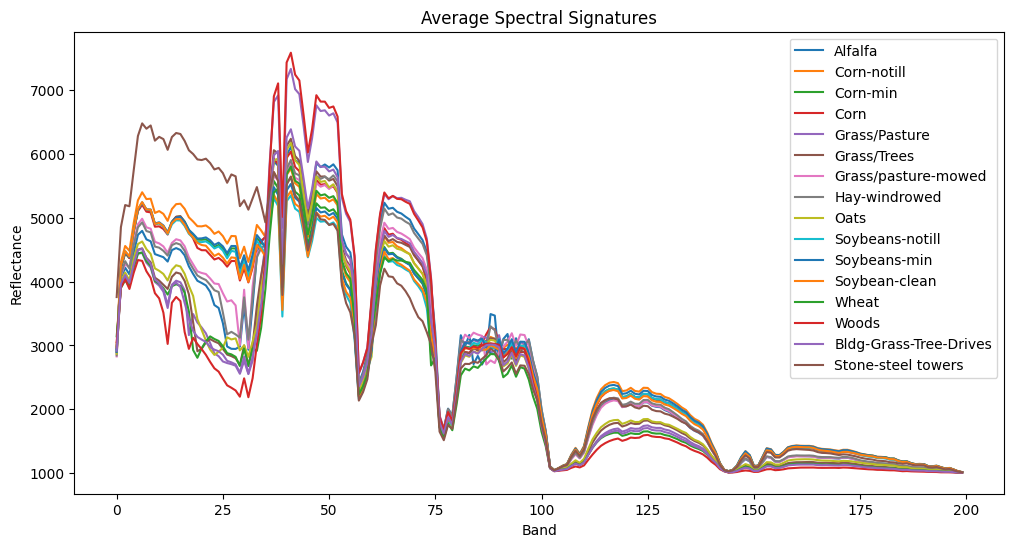

In [70]:
spectral_signatures = []
for cls in range(1, 17):
    class_df = df[df['class'] == cls]
    # Calculate average spectral signature across all pixels in the class
    avg_spectrum = class_df.drop(columns=['class']).mean(axis=0)
    spectral_signatures.append(avg_spectrum)
# Plot spectral signatures
plt.figure(figsize=(12, 6))
for i, spectrum in enumerate(spectral_signatures):
    plt.plot(spectrum.values, label=classes[i])
    

plt.title('Average Spectral Signatures')
plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

## Preprocessing

In [71]:
X,pca = applyPCA(X,numPCAcomponents)

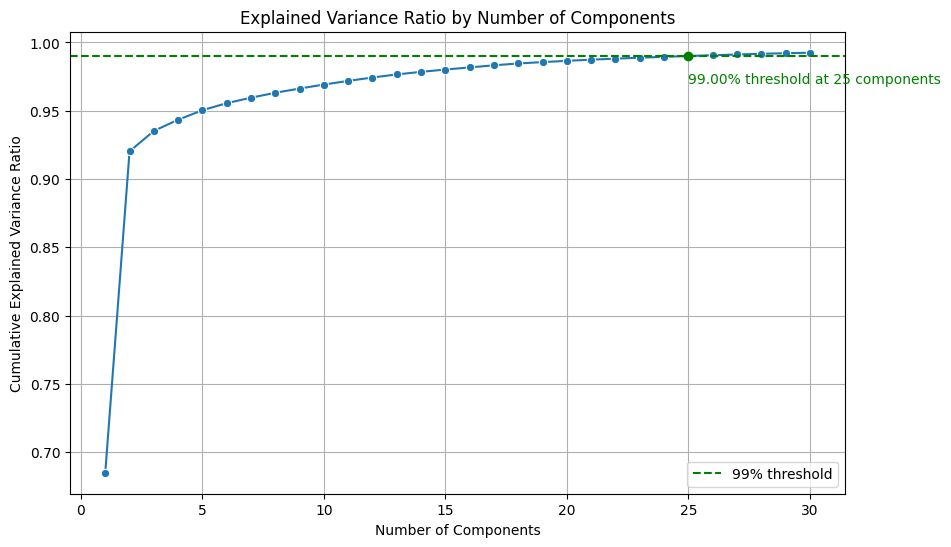

In [72]:
# Calculate explained variance ratio :  It's a measure of how much of the total 
#variance in the dataset is explained by each principal component.
threshold = 99 / 100

explained_variance_ratio = pca.explained_variance_ratio_

# Plot cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Create Seaborn plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.arange(1, len(cumulative_variance_ratio) + 1), y=cumulative_variance_ratio, marker='o')

# Find the index where cumulative explained variance ratio exceeds the threshold:  
#This point indicates the number of components needed to explain at least the specified threshold of variance.
index_threshold = np.argmax(cumulative_variance_ratio >= threshold)
# Plot a horizontal line at the threshold
plt.axhline(y=threshold, color='g', linestyle='--', label=f'{threshold:.0%} threshold')

# Highlight the threshold point
plt.scatter(index_threshold + 1, threshold, color='g', zorder=5)

# Annotate the x-coordinate of the threshold point
plt.text(index_threshold + 1, threshold - 0.02, f'{threshold:.2%} threshold at {index_threshold + 1} components', ha='left', c='g')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio by Number of Components')
plt.grid(True)
plt.legend()
plt.show()

plt.show()


By reducing the dimensionality from the original number of features (spectral bands) to 25 components, we retain 99% of the information contained in the data. This reduction in dimensionality can simplify subsequent analyses and make them more computationally efficient for us

In [73]:
XPatches, yPatches = createPatches(X, y, windowSize=windowSize)

In [74]:
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, testRatio)

In [75]:
X_train, y_train = oversampleWeakClasses(X_train, y_train)

In [76]:
X_train = AugmentData(X_train)

In [77]:
savePreprocessedData(X_train, X_test, y_train, y_test, windowSize = windowSize, 
                    wasPCAapplied=True, numPCAComponents = numPCAcomponents,testRatio = testRatio)

In [105]:
#savePreprocessedData(X_train, X_test, y_train, y_test, windowSize = windowSize, 
                  #  wasPCAapplied=False, numPCAComponents = 0,testRatio = testRatio)